### Categorize questions into [ color, shape, number, choose, YesNo, Others]
### Guids were also generated (in img_dataset_J_Qcate.json)
#### Set aside adversarial samples for [color, shape, number] based on Counter statistics. (ood guids are stored in pkl)
#### Create train/val/ind_test random splits for [color, shape, number]

In [149]:
import json
import numpy as np
import pylcs
from collections import Counter, defaultdict
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import random
import spacy
from sklearn.cluster import AgglomerativeClustering, KMeans
from nltk.corpus import stopwords
import torch
import uuid
nlp = spacy.load("en_core_web_sm", disable=["ner","textcat","parser"])

In [10]:
from word2number import w2n
def toNum(word):
    try: return w2n.word_to_num(word)
    except:
        return word

In [29]:
# This version has NO lemmatization.
# normalize_text for eval needs lemmatization
def normalize_text(s):
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text): # additional: converting numbers to digit form
        return " ".join([str(toNum(w)) for w in text.split()])
        #return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation) - set(['.'])
        text1 = "".join(ch for ch in text if ch not in exclude)
        return re.sub(r"\.(?!\d)", "", text1)

    def lower(text):
        return text.lower()
    
    #def lemmatization(text):
        #return " ".join([token.lemma_ for token in nlp(text)])
    if len(s.strip()) == 1:
        # FIXME: Is there a more general solution for handling answers like "+", "The"
        return white_space_fix(lower(s))
    if len(s.strip().split()) == 1: 
        return white_space_fix(remove_punc(lower(s)))
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [89]:
dataset_J_fix_dis = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_J_0623.json", "r"))
print([k for k in range(25474) if str(k) not in dataset_J_fix_dis])
print(Counter([len(dataset_J_fix_dis[j]['GoldIds']) for j in dataset_J_fix_dis]))

[233, 338, 443, 1233, 1234, 2141, 2361]
Counter({1: 14337, 2: 11130})


25467


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


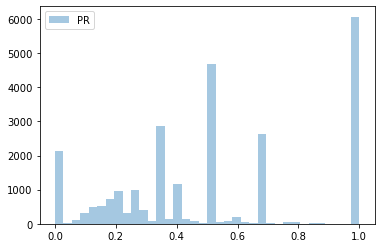

In [90]:
import pylcs
print(len(dataset_J_fix_dis))
overlap_ratio_list = []
id2ratio = {}
for k in dataset_J_fix_dis:
    A = normalize_text(dataset_J_fix_dis[k]['A'].replace('"', ''))
    B = normalize_text(dataset_J_fix_dis[k]['Q'].replace('"', ''))
    overlap_ratio = pylcs.lcs2(B, A) / len(A)
    id2ratio[k] = overlap_ratio
    overlap_ratio_list.append(overlap_ratio)

sns.distplot(overlap_ratio_list, kde=False, label="PR")
plt.legend()

In [101]:
# Pick color, shape and how many categories
dataset_J_Qcate = copy.deepcopy(dataset_J_fix_dis)
Qcate_dict = defaultdict(lambda: [])
for k in dataset_J_fix_dis:
    normalized_A = normalize_text(dataset_J_fix_dis[k]['A'].replace('"', ''))
    if 'what color' in dataset_J_fix_dis[k]['Q'].lower() or 'which color' in dataset_J_fix_dis[k]['Q'].lower() or 'what are the color' in dataset_J_fix_dis[k]['Q'].lower() or 'what is the color' in dataset_J_fix_dis[k]['Q'].lower():
        dataset_J_Qcate[k]['Qcate'] = 'color'
        Qcate_dict['color'].append(k)
    elif 'what shape' in dataset_J_fix_dis[k]['Q'].lower() or 'which shape' in dataset_J_fix_dis[k]['Q'].lower() or 'what are the shape' in dataset_J_fix_dis[k]['Q'].lower() or 'what is the shape' in dataset_J_fix_dis[k]['Q'].lower():
        dataset_J_Qcate[k]['Qcate'] = 'shape'
        Qcate_dict['shape'].append(k)
    elif 'how many' in dataset_J_fix_dis[k]['Q'].lower():
        dataset_J_Qcate[k]['Qcate'] = 'number'
        Qcate_dict['number'].append(k)
    
    elif id2ratio[k] > 0.8 and (not "what" in dataset_J_fix_dis[k]['Q'].lower()) and (len(normalized_A) > 1) and (not "no" == normalized_A) and (not normalized_A == "yes"):
        dataset_J_Qcate[k]['Qcate'] = 'choose'
        Qcate_dict['choose'].append(k)
    elif 'yes' in normalized_A.split() or 'no' in normalized_A.split():
        dataset_J_Qcate[k]['Qcate'] = 'YesNo'
        Qcate_dict['YesNo'].append(k)
    else:
        dataset_J_Qcate[k]['Qcate'] = 'Others'
        Qcate_dict['Others'].append(k)
    
    ### dataset_J_Qcate[k]['Guid'] = uuid.uuid1().hex # Guid was generated for img data on Jun 23. Never need to run this line again unless it's really necessary

for cate in Qcate_dict:
    print(cate, len(Qcate_dict[cate]))
print(Counter([dataset_J_Qcate[k]['Qcate'] for k in dataset_J_Qcate]))
print(len(set([dataset_J_Qcate[k]['Guid'] for k in dataset_J_Qcate])))

Others 6748
YesNo 8432
choose 5240
number 2341
shape 662
color 2044
Counter({'YesNo': 8432, 'Others': 6748, 'choose': 5240, 'number': 2341, 'color': 2044, 'shape': 662})
25467


In [102]:
json.dump(dataset_J_Qcate, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_J_Qcate.json", "w"), indent=4)

### Start working on adversarial splits for [color, shape, number]

In [165]:
# Sanity check after img_dataset_J_Qcate.json is fixed
dataset_J_Qcate = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_J_Qcate.json", "r"))
print(Counter([dataset_J_Qcate[k]['Qcate'] for k in dataset_J_Qcate]))
print(len(set([dataset_J_Qcate[k]['Guid'] for k in dataset_J_Qcate])))
print(Counter([len(dataset_J_Qcate[j]['GoldIds']) for j in dataset_J_Qcate]))
print([k for k in range(25474) if str(k) not in dataset_J_Qcate])

Counter({'YesNo': 8432, 'Others': 6748, 'choose': 5240, 'number': 2341, 'color': 2044, 'shape': 662})
25467
Counter({1: 14337, 2: 11130})
[233, 338, 443, 1233, 1234, 2141, 2361]


In [108]:
# Check what fall into "Others" category
count = 0
for k in dataset_J_Qcate:
    
    if dataset_J_Qcate[k]['Qcate'] == 'Others' and count < 10:
        if random.random() < 0.02:
            print(dataset_J_Qcate[k]['Q'])
            print(dataset_J_Qcate[k]['A'])
            count += 1

"What building material is prominent throughout the interior of the James R. Browning courthouse?"
"Marble"
"What numbers were worn on the jerseys of those playing in the final match of the 2014 FIFA World Cup?"
"11, 14, 8, 16, 20, 9"
"What is tacked at the bottom of the Hartford Textile Co. pieces at the Library of Congress?"
"A ruler."
"What can be seen in the interior walls of San Francisco City Hall?"
"Sculptures and inscriptions"
"What is the largest structure that can be seen on the Las Vegas strip?"
"The Eiffel Tower of Las Vegas"
"Which companies have billboards behind the police station in Times Square?"
"Yahoo, Panasonic, News Corporation, Budweiser, Chevrolet, Ricoh"
"What street signs are next to the building that has a "Gerrard Street W1" sign at the corner of Gerrard St in China Town, London?"
"Pedestrian zone; Except loading"
"What kind of shutters does Rocky's Pizzeria on Coney Island Ave use to lock down its shop when it isn't open?"
"Rolling steel shutters"
"What two 

In [135]:
color_counter = Counter([normalize_text(dataset_J_Qcate[k]['A'].replace('"', '')) for k in dataset_J_Qcate if dataset_J_Qcate[k]['Qcate'] == 'color'])
#print(color_counter)
d = defaultdict(lambda: [])
for a in color_counter.keys():
    if len(a.split()) == 1:
        d[a].append(a)
for a in color_counter.keys():
    if len(a.split()) > 1:
        assigned = False
        for w in a.split():
            for single_color in d:
                if single_color in w:
                    d[single_color].append(a)
                    assigned = True
        if not assigned:
            print(a)
for single_color in d:
    print(single_color, len(d[single_color]))
#pprint(d)

ash color
stained glass
olive color
neutralbased color scheme
blue 99
yellow 86
red 111
white 105
green 77
pink 28
orange 32
gold 26
black 53
brown 26
purple 21
orangepurple 1
silver 10
grey 21
gray 9
teal 2
tan 5
golden 3
rust 2
ivory 1
maroon 2
bluered 1
aqua 1
rainbow 1
blonde 2
transparent 2
turquoise 2
spotted 1
yes 1
beige 3
orangebrown 1
bronze 1
violet 3
bluewhite 1
chrome 1
redorange 1


In [140]:
# blue and purple go into adversarial set. Long tail was devided randomly

color_ood_answer = []
color_ood_guid = []
for k in dataset_J_Qcate:
    if dataset_J_Qcate[k]['Qcate'] == 'color':
        normalize_A = normalize_text(dataset_J_Qcate[k]['A'].replace('"', ''))
        if 'blue' in normalize_A or 'purple' in normalize_A:
            if len(normalize_A) > 10:
                if random.random() < 0.1:
                    color_ood_guid.append(dataset_J_Qcate[k]['Guid'])
                    color_ood_answer.append(normalize_A)
            else:
                color_ood_guid.append(dataset_J_Qcate[k]['Guid'])
                color_ood_answer.append(normalize_A)
        elif len(normalize_A.split()) == 1:
            if len(d[normalize_A]) <= 5: 
                if random.random() < 0.1:
                    color_ood_guid.append(dataset_J_Qcate[k]['Guid'])
                    color_ood_answer.append(normalize_A)
print(len(color_ood_guid))
print(Counter(color_ood_answer))

232
Counter({'blue': 170, 'purple': 30, 'light blue': 9, 'red blue': 2, 'red blue grey': 1, 'blue and tan': 1, 'black red and blue': 1, 'blue white': 1, 'bluered': 1, 'green blue': 1, 'blue white and red': 1, 'navy blue': 1, 'yes': 1, 'bronze': 1, 'red white and blue': 1, 'violet': 1, 'blue white and green': 1, 'blue white black': 1, 'orange silver red blue': 1, 'red black green yellow blue': 1, 'bluewhite': 1, 'blue and turquoise': 1, 'brown yellow green and blue': 1, 'green red yellow and blue': 1, 'white blue': 1})


In [187]:
# Give up on using BERT embeddings to cluster shapes.
# Pick out 'triangle', 'triangular', 'triangles', 'pyramid', 'cone',  and others go into training. Long tail was decided randomly
ood_shapes = ['triangle', 'triangular', 'pyramid', 'cone']
shape_ood_answer = []
shape_ood_guid = []

shape_counter = Counter([normalize_text(dataset_J_Qcate[k]['A'].replace('"', '')) for k in dataset_J_Qcate if dataset_J_Qcate[k]['Qcate'] == 'shape'])

for k in dataset_J_Qcate:
    if dataset_J_Qcate[k]['Qcate'] == 'shape':
        normalize_A = normalize_text(dataset_J_Qcate[k]['A'].replace('"', ''))
        
        for s in ood_shapes:
            if s in normalize_A:
                shape_ood_guid.append(dataset_J_Qcate[k]['Guid'])
                shape_ood_answer.append(normalize_A)
                break

        if normalize_A not in shape_ood_answer:
            if shape_counter[normalize_A] <= 5:
                if random.random() < 0.1:
                    shape_ood_guid.append(dataset_J_Qcate[k]['Guid'])
                    shape_ood_answer.append(normalize_A)
            
print(len(shape_ood_guid))
print(Counter(shape_ood_answer))

97
Counter({'triangle': 41, 'triangles': 11, 'pyramid': 9, 'triangular': 7, 'cone': 5, 'triangular pyramid': 1, 'cone shape': 1, 'forked': 1, 'upside down pyramid': 1, 'bell': 1, 'pyramidal': 1, 'bow': 1, 'sloped': 1, 'dome shaped': 1, 'square circle triangle': 1, 'diamonds': 1, 'upside down cone': 1, 'curved rounded shapes': 1, 'domed': 1, 'spirals': 1, 'oval triangle': 1, 'wavy': 1, 'hexagon': 1, 'pointy pyramid': 1, 'cone shaped': 1, 'cones': 1, 'cylinder': 1, 'square triangle': 1, 'squares triangles and curves': 1})


In [173]:
def extract_number(s):
    for i in s.split():
        if str(toNum(i)).isdigit():
            return toNum(i)
        try:
            return float(i)
        except: pass
    return s

In [177]:
# 5, 8 go into adversarial set. Long tail was decided randomly
number_counter = Counter([extract_number(normalize_text(dataset_J_Qcate[k]['A'].replace('"', ''))) for k in dataset_J_Qcate if dataset_J_Qcate[k]['Qcate'] == 'number'])
print(sum(list(number_counter.values())))
print(number_counter)

number_ood_answer = []
number_ood_guid = []

for k in dataset_J_Qcate:
    if dataset_J_Qcate[k]['Qcate'] == 'number':
        number_in_A = extract_number(normalize_text(dataset_J_Qcate[k]['A'].replace('"', '')))
        
        if number_in_A in [5, 8]:
            number_ood_guid.append(dataset_J_Qcate[k]['Guid'])
            number_ood_answer.append(number_in_A)

        elif number_counter[number_in_A] <= 5:
            if random.random() < 0.1:
                number_ood_guid.append(dataset_J_Qcate[k]['Guid'])
                number_ood_answer.append(number_in_A)
            
print(len(number_ood_guid))
print(Counter(number_ood_answer))

2341
Counter({2: 732, 3: 428, 4: 332, 1: 261, 5: 152, 6: 141, 8: 65, 7: 49, 0: 32, 10: 25, 9: 25, 11: 22, 13: 13, 12: 11, 14: 9, 'twice': 8, 'none': 5, 'once': 4, 15: 3, 17: 3, 16: 3, 28: 2, 25: 2, 30: 2, 18: 1, 'thirtythree': 1, 26: 1, 'thirtynine': 1, 36: 1, 20: 1, 22: 1, 'twentytwo': 1, 'oneway': 1, 'twentysix': 1, 50: 1, 19: 1})
221
Counter({5: 152, 8: 65, 25: 1, 'thirtynine': 1, 36: 1, 20: 1})


In [188]:
color_shape_number_ood_guid = color_ood_guid + shape_ood_guid + number_ood_guid
print(len(set(color_shape_number_ood_guid)))

550


In [203]:
import pickle
# pickle.dump(color_shape_number_ood_guid, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/color_shape_number_ood_guid.pkl", "wb"))
# color shape number ood guid was fixed on Jun 24

### Randomly assign train/val/ind_test for [color, shape, number]

In [204]:
# Sanity check after ood guids were created for [color, shape, number]
color_shape_number_ood_guid = pickle.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/color_shape_number_ood_guid.pkl", "rb"))
assert len(color_shape_number_ood_guid) == len(set(color_shape_number_ood_guid))
print(len(color_shape_number_ood_guid))

550


In [213]:
img_data_J_color_shape_number_have_split = copy.deepcopy(dataset_J_Qcate)
for k in img_data_J_color_shape_number_have_split:
    if img_data_J_color_shape_number_have_split[k]['Qcate'] in ['color', 'shape', 'number']:
        if img_data_J_color_shape_number_have_split[k]['Guid'] in color_shape_number_ood_guid:
            img_data_J_color_shape_number_have_split[k]['split'] = 'ood_test'
        else:
            if random.random() < 7/9:
                img_data_J_color_shape_number_have_split[k]['split'] = 'train'
            elif random.random() < 0.5:
                img_data_J_color_shape_number_have_split[k]['split'] = 'val'
            else:
                img_data_J_color_shape_number_have_split[k]['split'] = 'ind_test'
    else: img_data_J_color_shape_number_have_split[k]['split'] = 'tbd'
print(Counter([img_data_J_color_shape_number_have_split[k]['split'] for k in img_data_J_color_shape_number_have_split]))

Counter({'tbd': 20420, 'train': 3460, 'ood_test': 550, 'ind_test': 525, 'val': 512})


In [214]:
# json.dump(img_data_J_color_shape_number_have_split, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_data_J_color_shape_number_have_split.json", "w"), indent=4)
# ood guid for color shape number was decided on Jun 24. 
# Random split into train/val/ind_test was created on Jun 24